<a href="https://colab.research.google.com/github/JerryTheGOATChen/stockML/blob/main/Stocks_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0.5717566016073479

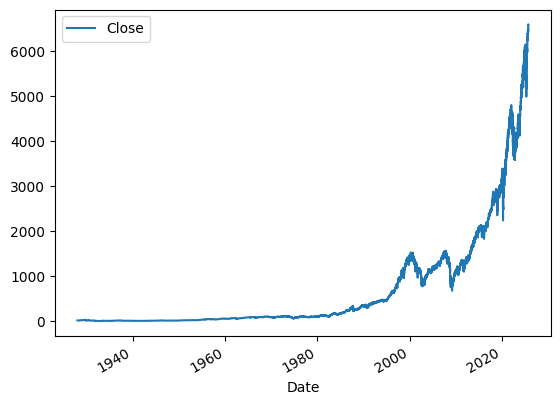

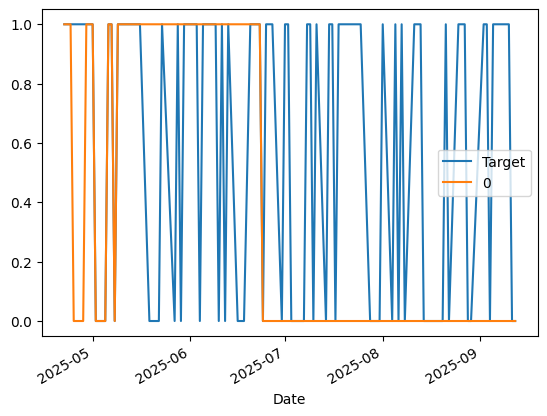

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier #Random Forest Algorithm
from sklearn.metrics import precision_score #Accuracy metric

sp500 = yf.Ticker("^GSPC")        #Tracks S&P500 data as a ticker
sp500 = sp500.history(period="max")
sp500.index
sp500.plot.line(y="Close", use_index=True)
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)  #Returns boolean as int for ML
sp500 = sp500.loc["1990":].copy() #Tracks S&P500 data from 1990 and onwards

#Training an initial machine learning model
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

train = sp500.iloc[:-100]    #Put all rows instead of last 100 into training set
test = sp500.iloc[-100:]    #Puts last 100 rows into the test set

predictors = ["Close", "Volume", "Open", "High", "Low" ] #Don't use tommorow or predictor set as that is knowing the future
model.fit(train[predictors], train["Target"])
RandomForestClassifier(min_samples_split=100, random_state=1)
preds = model.predict(test[predictors])    #Precision score, generates score using model
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)
combined = pd.concat([test["Target"], preds], axis=1) #Treat each input as a column
combined.plot()

#Prediction Functions
def predict(train, test, predictors, model):  #Wraps everything we have done into one function
  model.fit(train[predictors], train["Target"])
  preds = model.predict_proba(test[predictors]) [:,1]
  preds[preds >= 0.6] = 1
  preds[preds <0.6] = 0
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

#Backtesting functions
def backtest(data, model, predictors, start=2500, step=250):  #Take 10 years of data and train with that, in increments of 1 year
  all_predictions = []

  for i in range(start,data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

predictions = backtest(sp500, model, predictors) # Use original predictors for initial backtest
predictions["Predictions"].value_counts()
precision_score(predictions["Target"], predictions["Predictions"])
predictions["Target"].value_counts()/predictions.shape[0]

#Adding additional predictors to the model

horizons = [2,5,60,250,1000]    #Rolling averages
new_predictors = []

for horizon in horizons:
  rolling_averages = sp500.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

  trend_column = f"Trend_{horizon}"
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum() ["Target"] #Finds rolling sum of past few days

  new_predictors += [ratio_column, trend_column]
sp500 = sp500.dropna()
predictions = backtest(sp500, model, new_predictors)
predictions["Predictions"].value_counts()
precision_score(predictions["Target"], predictions["Predictions"])
#future steps - add in news (hard), add in key sectors ie tech,